In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.special import loggamma
from statsmodels.sandbox.distributions.mv_normal import MVT
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle
from fastcache import lru_cache
import inspect

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%load_ext Cython
%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120

# B&O Model Checking Implementation

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
That is what this notebook aims to do.

## Model Checking for GPs (Source Code)

Let's start with model checking diagnostics that assumes everything is Gaussian. We don't need to integrate out parameters yet, and instead be content with MAP values for now.

Here are some utility functions that will prove useful later.

In [3]:
def lazy_property(function):
    R"""Stores as a hidden attribute if it doesn't exist yet, else it returns the hidden attribute.
    
    This means that any method decorated with this function will only be computed if necessary, and will be
    stored if needed to be called again.
    """
    attribute = '_cache_' + function.__name__

    @property
    @wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator            


def lazy(function):
    attribute = '_cache_' + function.__name__

    @wraps(function)
    def decorator(self, *args, **kwargs):
        lazy = True

        # If y are passed and are not the defaults
        y = kwargs.pop('y', None)
        if y is not None and not np.allclose(y, self.y):
            lazy = False
        else:
            y = self.y

        # If cholesky is passed and are not the defaults
        corr_chol = kwargs.pop('corr_chol', None)
        if corr_chol is not None and not np.allclose(corr_chol, self._corr_chol):
            lazy = False
        else:
            corr_chol = self._corr_chol

        if not lazy or not hasattr(self, attribute):
            setattr(self, attribute, function(self, *args, y=y, corr_chol=corr_chol, **kwargs))
        return getattr(self, attribute)
    return decorator


def default_attributes(**kws):
    """Sets `None` or `{}` arguments to attributes already stored in a class.
    
    This is a handy decorator to avoid `if` statements at the beginning of method
    calls, but is particularly useful when the function uses a cache to avoid
    unnecessary computations. Caches don't recognize when the attributes change,
    so could result in incorrect returned values. This decorator **must** be put
    outside of the cache decorator though.
    
    Parameters
    ----------
    kws : dict
        The key must match the parameter name in the decorated function, and the value
        corresponds to the name of the attribute to use as the default
        
    Example
    -------
    from fastcache import lru_cache
    
    class TestClass:
    
        def __init__(self, x, y):
            self.x = x
            self._y = y

        @lru_cache()
        def add(self, x=None, y=None):
            if x is None:
                x = self.x
            if y is None:
                y = self._y
            return x + y

        @lru_cache()
        @default_attributes(x='x', y='_y')
        def add2(self, x=None, y=None):
            return x + y

        @default_attributes(x='x', y='_y')
        @lru_cache()
        def add_correctly(self, x=None, y=None):
            return x + y

    tc = TestClass(2, 3)
    print(tc.add(), tc.add2(), tc.add_correctly())  # Prints 5 5 5
    tc.x = 20
    print(tc.add(), tc.add2(), tc.add_correctly())  # Prints 5 5 23
    tc._y = 5
    print(tc.add(), tc.add2(), tc.add_correctly())  # Prints 5 5 25
    """
    def decorator(function):
        sig = inspect.signature(function)

        @wraps(function)
        def new_func(self, *args, **kwargs):
            # Puts all arguments---positional, keyword, and default---explicitly in bound_args
            bound_args = sig.bind(self, *args, **kwargs)
            bound_args.apply_defaults()
            # Now loop over the dict and update the `None` arguments if specified by kws
            for key, value in bound_args.arguments.items():
                param = sig.parameters[key]
                
                if isinstance(value, np.ndarray):
                    continue
                
                # Update standard arguments if they are `None`, but also allow for
                # *args and **kwargs to be set to defaults if they are empty.
                # Standard arguments:
                default_poskey = value is None and param.kind == param.POSITIONAL_OR_KEYWORD
                # Keyword only arguments (comes after *args):
                default_key = value is None and param.kind == param.KEYWORD_ONLY
                # *args argument:
                default_varpos = value == () and param.kind == param.VAR_POSITIONAL
                # **kwargs argument:
                default_varkey = value == {} and param.kind == param.VAR_KEYWORD

                if (default_poskey or default_key or default_varpos or default_varkey) and key in kws:
                    bound_args.arguments[key] = getattr(self, kws[key])
            return function(*bound_args.args, **bound_args.kwargs)
        return new_func
    return decorator

vec_solve_triangular = np.vectorize(sp.linalg.solve_triangular, excluded=['lower'], signature='(m,m),(m,n)->(m,n)')

def chol_errors(y, mean, chol):
    y = np.atleast_2d(y)
    return np.squeeze(np.swapaxes(vec_solve_triangular(chol, (y - mean).T, lower=True), -1, -2))

# def chol_errors(y, mean, chol):
#     return sp.linalg.solve_triangular(chol, (y - mean).T, lower=True).T

def mahalanobis(y, mean, chol):
    err = chol_errors(y, mean, chol)
    return np.linalg.norm(err, axis=-1)

def rbf(X, Xp=None, ls=1):
    if Xp is None:
        Xp = X
    diff = X[:, None, ...] - Xp[None, ...]
    dist = np.linalg.norm(diff, axis=-1)
    if ls == 0:
        return np.where(dist == 0, 1., 0.)
    return np.exp(- dist**2 / ls**2)

In [4]:
z = np.linspace(0, 1, 10)
z2 = np.linspace(0, 1, 9)
# R = np.apply_along_axis(lambda L: rbf(z[:, None], z2[:, None], ls=L), 1, np.arange(1, 5)[:, None])
R = np.array([rbf(z[:, None], z2[:, None], ls=L) for L in np.arange(0.1, 3, 0.5)])
print(R.shape)

(6, 10, 9)


In [5]:
# rr = np.random.rand(5, 5)
# rr = rr + rr.T + 5*np.eye(5)
# rrchol = np.linalg.cholesky(rr)
# rr2 = np.random.rand(5, 5)
# rr2 = rr2 + rr2.T + 5*np.eye(5)
# v = np.random.rand(3,5)
# vv = np.random.rand(5)
# # vstack = np.stack([v, vv])
# rstack = np.stack([rr, rr2])
# rstackchol = np.linalg.cholesky(rstack)

# print(chol_errors(v, np.zeros_like(v), rrchol))
# print(mahalanobis(v, np.zeros_like(v), rrchol))

# print(chol_errors(v, np.zeros_like(v), rstackchol))
# print(mahalanobis(v, np.zeros_like(v), rstackchol))


# print(rstackchol.shape)
# # np.vectorize()
# print(vec_solve_triangular(rstackchol, v[:, None]))
# print(vec_solve_triangular(rstackchol[0], v[:, None]))
# print(sp.linalg.solve_triangular(rstackchol[0], v))
# print(sp.linalg.solve_triangular(rstackchol[1], v))

# print(sp.linalg.solve_triangular(rstackchol[0], vstack.T))
# print(vec_solve_triangular(rstackchol, vstack.T))
# np.linalg.solve()
# np.apply_over_axes()

In [6]:
class TestClass:
    
    def __init__(self, x, y):
        self.x = x
        self._y = y
        self.adict = {'a': 1, 'b': 2, 'c': 3}
        self.alist = [1, 2, 7]
    
    @lru_cache()
    def add(self, x=None, y=None):
        if x is None:
            x = self.x
        if y is None:
            y = self._y
        return x + y
    
    @lru_cache()
    @default_attributes(x='x', y='_y')
    def add2(self, x=None, y=None):
        return x + y
    
    @default_attributes(x='x', y='_y', args='alist', kwargs='adict')
    @lru_cache()
    def add_correctly(self, x=None, y=None, *args, **kwargs):
        return x + y

tc = TestClass(2, 3)
print(tc.add(), tc.add2(), tc.add_correctly())
tc.x = 20
print(tc.add(), tc.add2(), tc.add_correctly())
tc._y = 5
print(tc.add(), tc.add2(), tc.add_correctly())

5 5 5
5 5 23
5 5 25


Python has no pivoted cholesky decomposition, so I made one myself from `gsl`

In [7]:
%%cython -lgsl -lgslcblas
cimport cython
from cython_gsl cimport *
import numpy as np
cimport numpy as np

cdef extern from "gsl/gsl_linalg.h":
    # Pivoted Cholesky Decomposition
    int  gsl_linalg_pcholesky_decomp(gsl_matrix * A, gsl_permutation * P) nogil

cdef extern from "gsl/gsl_permutation.h":
    int gsl_permute_matrix (const gsl_permutation * p, gsl_matrix * A)


def pivoted_chol_cython(arr):
    # Variable sized array info stolen from
    # http://docs.cython.org/en/latest/src/userguide/memoryviews.html#pass-data-from-a-c-function-via-pointer
    if not arr.flags['C_CONTIGUOUS']:
        arr = np.ascontiguousarray(arr) # Makes a contiguous copy of the numpy array.
    n = arr.shape[0]
    cdef double[::1] aa = arr.ravel().copy()
    cdef double[::1] ii = np.eye(n).ravel()
    cdef gsl_permutation *P
    # GSL wants its special gsl matrices
    P = gsl_permutation_alloc(n)
    A = gsl_matrix_view_array(&aa[0], n, n)
    I = gsl_matrix_view_array(&ii[0], n, n)

    # This constructs LDL^T where L is lower triangular with ones on the diagonal
    # Turns aa into a matrix with L on the lower triangle, D on the diagonal, and ones on the upper triangle
    gsl_linalg_pcholesky_decomp(&A.matrix, P)

    # Now create lower triangular matrix R from aa described above
    chol = np.tril(np.array(aa).reshape(arr.shape))
    d = np.sqrt(np.diag(chol))
    chol[range(n), range(n)] = 1.
    # Multiply column i by d_i
    chol *= d
    
    # P is some permutation object but I want a matrix
    gsl_permute_matrix(P, &I.matrix)  # Permute the identity to turn ii into a permutation matrix
    perm = np.array(ii).reshape(arr.shape)
    return perm @ chol

Prove that the pivoted cholesky I wrote above works:

In [8]:
np.random.seed(1)
# m = np.ones((4, 4)) + 2 * np.eye(4)
r = np.random.rand(4, 4)
m = r + r.T + 2 * np.eye(4)
G_pc = pivoted_chol_cython(m)

# print('R\n', pc, '\n\nP\n', pp, '\n')
# G = pp @ pc
print('M original\n', m, '\n')
print('G\n', G_pc, '\n')
# print(G @ G.T)
print('G.G^T = M?', np.allclose(G_pc @ G_pc.T, m))

M original
 [[2.83404401 0.86708038 0.39688185 0.50678482]
 [0.86708038 2.18467719 0.72507695 1.22367816]
 [0.39688185 0.72507695 2.83838903 0.71260709]
 [0.50678482 1.22367816 0.71260709 3.34093502]] 

G
 [[0.27726151 1.66047284 0.         0.        ]
 [0.6694732  0.41040191 0.24095152 1.22881873]
 [0.38986669 0.17391843 1.6297685  0.        ]
 [1.82782248 0.         0.         0.        ]] 

G.G^T = M? True


Now let's define a GP class that behaves like `GaussianProcessRegressor` in `scikit-learn`, but analytically computes MAP values for means and covariances when multiple iid curves are examined.

In [9]:
# CACHE_SIZE = 200

class ConjugateProcess:
    
    def __init__(self, corr_kernel, m0=0, v0=1, a0=1, b0=1):
        """A conjugate Gaussian Process model
        
        Parameters
        ----------
        corr_kernel : callable
            The kernel for the correlation matrix
        m0 : float
            The mean hyperparameter for the normal prior placed on the mean
        v0 : float
            The variance hyperparameter for the normal prior placed on the mean
        a0 : float > 0
            The shape hyperparameter for the inverse gamma prior placed on sd**2
        b0 : float > 0
            The scale hyperparameter for the inverse gamma prior placed on sd**2
        """
        self.m0 = m0
        self.v0 = v0
        self.a0 = a0
        self.b0 = b0
        self.corr_kernel = corr_kernel
        self.X = None
        self.y = None
        self.corr_kwargs = {}
        self._corr_chol = None
        self.noise_sd = 1e-7
        # if ratio_func is None:
        #     self.ratio_func = lambda x, *args, **kwargs: np.ones(len(x))
        
    def _recompute_corr(self, **corr_kwargs):
        # Must be non-empty and not equal to the defaults
        return corr_kwargs and corr_kwargs != self.corr_kwargs
    
    def cleanup(self):
        """Removes all attributes except those set at initialization"""
        def attr_name(name):
            return '_cache_' + name
        for attr in ['y', 'X', 'corr']:
            try:
                delattr(self, attr)
            except AttributeError:
                pass
        for attr in ['m', 'v', 'a', 'b', 'sd']:
            try:
                delattr(self, attr_name(attr))
            except AttributeError:
                pass
    
    @default_attributes(y='y', corr_chol='_corr_chol')
    # @lru_cache(CACHE_SIZE)
    def m(self, y=None, corr_chol=None):
        """The posterior mean hyperparameter given y for the normal prior placed on the GP mean"""
        # Mean is not updated if its prior variance is zero (i.e. delta function prior)
        # Do by hand to prevent dividing by zero
        if self.v0 == 0:
            return self.m0

        y_avg = y
        if y.ndim == 2:
            y_avg = np.average(y, axis=0)
        ny = self.num_y(y)
        one = np.ones_like(y_avg)
        # print(y_avg.shape, corr_chol.shape)
        right_half = chol_errors(y_avg, 0, corr_chol)
        left_half = chol_errors(one, 0, corr_chol)
        # if left_half.ndim > 1:
        #     left_half = np.swapaxes(left_half, -1, -2)
        v = self.v(y=y, corr_chol=corr_chol)
        return v * (self.m0 / self.v0 + ny * np.sum(left_half * right_half, axis=-1))
    
    @default_attributes(y='y', corr_chol='_corr_chol')
    # @lru_cache(CACHE_SIZE)
    def v(self, y=None, corr_chol=None):
        """The posterior variance hyperparameter for the normal prior placed on the mean"""
        # If prior variance is zero, it stays zero
        # Do by hand to prevent dividing by zero
        if self.v0 == 0:
            return 0

        ny = self.num_y(y)
        one = np.ones(corr_chol.shape[-1])
        quad = mahalanobis(one, 0, corr_chol) ** 2
        return (1. / self.v0 + ny * quad) ** (-1)
    
    @default_attributes(y='y')
    def a(self, y=None):
        """The posterior shape hyperparameter for the inverse gamma prior placed on sd**2"""
        return self.a0 + y.size / 2.
    
    @default_attributes(y='y', corr_chol='_corr_chol')
    # @lru_cache(CACHE_SIZE)
    def b(self, y=None, corr_chol=None):
        """The posterior scale hyperparameter for the inverse gamma prior placed on sd**2"""
        mean_terms = 0
        if self.v0 != 0:
            m = self.m(y=y, corr_chol=corr_chol)
            v = self.v(y=y, corr_chol=corr_chol)
            mean_terms = self.m0**2 / self.v0 - m**2 / v
        quad = np.sum(mahalanobis(y, 0, corr_chol)**2, axis=-1)
        return self.b0 + 0.5 * (mean_terms + quad)
    
    @default_attributes(y='y', corr_chol='_corr_chol')
    # @lru_cache(CACHE_SIZE)
    def sd(self, y=None, corr_chol=None, broadcast=False):
        """The mean value for the marginal standard deviation given y.
        
        It turns out that for both the GP and TP, `sd**2` is the conversion factor to go
        from the correlation matrix to the covariance matrix.
        
        Note: if the correlation matrix does equal 1 when `X == Xp`, `sd` **will not**
        be the standard deviation at `X`. Instead, one must look at `cov` directly.
        """
        b = self.b(y=y, corr_chol=corr_chol)
        a = self.a(y=y)
        sd = np.sqrt(b / (a - 1))
        if broadcast:  # For when a set of corr_chols are given
            sd = np.atleast_1d(sd)[:, None, None]
        return sd

    @default_attributes(X='X', y='y', corr_chol='_corr_chol')
    def mean(self, X=None, y=None, corr_chol=None):
        """The MAP value for the mean given y"""
        m = np.atleast_1d(self.m(y=y, corr_chol=corr_chol))[:, None]
        return np.squeeze(m * np.ones(len(X)))

    @default_attributes(X='X', Xp='X', y='y', noise_sd='noise_sd', kwargs='corr_kwargs')
    def cov(self, X=None, Xp=None, y=None, noise_sd=None, **kwargs):
        corr = self.corr_kernel(X, Xp, **kwargs)
        corr_chol = self.corr_chol(noise_sd=noise_sd, **kwargs)  # use X from fit
        sd = self.sd(y=y, corr_chol=corr_chol, broadcast=True)
        return np.squeeze(sd**2 * corr)
    
    @default_attributes(X='X', noise_sd='noise_sd', kwargs='corr_kwargs')
    def corr_chol(self, X=None, noise_sd=None, **kwargs):
        attr = '_corr_chol'
        corr = self.corr_kernel(X, X, **kwargs)
        chol = np.linalg.cholesky(corr + noise_sd**2 * np.eye(len(X)))
        # if (kwargs and kwargs != self.corr_kwargs) or not hasattr(self, attr):
        #     corr = self.corr_kernel(X, X, **kwargs)
        #     chol = np.linalg.cholesky(corr + noise_sd**2 * np.eye(len(X)))
        #     setattr(self, attr, chol)
        # return getattr(self, attr)
        return chol
    
    @staticmethod
    def num_y(y):
        ny = 1
        if y.ndim == 2:
            ny = y.shape[0]
        return ny
    
    def fit(self, X, y, noise_sd=1e-7, **kwargs):
        """Fits the GP, i.e., sets/updates all hyperparameters, given y(X)"""
        # self.cleanup()
        self.X = X
        # self.y_original = y
        # if ratio_kwargs is None:
        #     ratio_kwargs = {}
        # self.ratio_kwargs = ratio_kwargs
        # self.ratio = self.ratio_func(X, **ratio_kwargs)
        # if orders is None:
        #     ny = self.num_y(y)
        #     self.orders = np.arange(ny)
        # self.y = y / self.ratio ** self.orders[:, None]
        self.y = y
        self.corr_kwargs = kwargs
        self.noise_sd = noise_sd
        self.corr = self.corr_kernel(X, **kwargs)
        self._corr_chol = self.corr_chol(X, noise_sd=noise_sd, **kwargs)
    
    @default_attributes(y='y')
    def predict(self, Xnew, return_std=False, return_cov=False, y=None, pred_noise=True):
        """Returns the predictive GP at unevaluated points Xnew"""
        # if kwargs is not None:
        #     self.fit(self.X, self.y, self.noise_sd, **kwargs)
        kwargs = self.corr_kwargs
        # corr_chol = self.corr_chol(**kwargs)
        corr_chol = self._corr_chol
        # Use y from fit for hyperparameters
        m_old = self.mean(y=self.y, corr_chol=corr_chol)
        m_new = self.mean(Xnew, y=self.y, corr_chol=corr_chol)
        R_on = self.corr_kernel(self.X, Xnew, **kwargs)
        R_no = R_on.T
        R_nn = self.corr_kernel(Xnew, Xnew, **kwargs)

        # Use given y for prediction
        mfilter = np.dot(R_no, sp.linalg.cho_solve((corr_chol, True), (y - m_old).T)).T
        m_pred = m_new + mfilter
        if return_std or return_cov:
            half_quad = sp.linalg.solve_triangular(corr_chol, R_on, lower=True)
            R_pred = R_nn - np.dot(half_quad.T, half_quad)
            if pred_noise:
                R_pred += self.noise_sd**2 * np.eye(len(Xnew))
            # Use y from fit for hyperparameters
            sd = self.sd(y=self.y, corr_chol=corr_chol, broadcast=True)
            K_pred = np.squeeze(sd**2 * R_pred)
            if return_std:
                return m_pred, np.sqrt(np.diag(K_pred))
            return m_pred, K_pred
        return m_pred
    
    @default_attributes(y='y', corr_chol='_corr_chol')
    def likelihood(self, log=True, y=None, corr_chol=None):
        raise NotImplementedError
        
    def corr_posterior(self, name, mesh):
        pass

        
class ConjugateGaussianProcess(ConjugateProcess):
    
    @default_attributes(y='y', corr_chol='_corr_chol')
    def likelihood(self, log=True, y=None, corr_chol=None):
        # Setup best guesses for mean and cov
        means = np.atleast_2d(self.mean(y=y, corr_chol=corr_chol))
        sd = self.sd(y=y, corr_chol=corr_chol, broadcast=True)
        corrs = corr_chol @ np.swapaxes(corr_chol, -2, -1)
        covs = sd**2 * corrs
        
        # sd is the length of the corr_chols passed (default is 1)
        # Multiple corr_chols can be passed to quickly get likelihoods for many correlation parameters
        n = len(sd)
        loglikes = np.zeros(n)
        for i in range(n):
            dist = stats.multivariate_normal(mean=means[i], cov=covs[i])
            loglikes[i] = np.sum(dist.logpdf(y))
        loglikes = np.squeeze(loglikes)
        if log:
            return loglikes
        return np.exp(loglikes)

    
class ConjugateStudentProcess(ConjugateProcess):
    
    @default_attributes(y='y', corr_chol='_corr_chol')
    def likelihood(self, log=True, y=None, corr_chol=None):
        mean = self.mean(y=y, corr_chol=corr_chol)
        # chol = corr_chol
        a0, a = self.a0, self.a(y=y)
        b0, b = self.b0, self.b(y=y, corr_chol=corr_chol)
        v0, v = self.v0, self.v(y=y, corr_chol=corr_chol)
        ny = self.num_y(y)
        N = chol.shape[-1]
        
        def log_nig_norm(aa, bb, vv):
            """Normalization of the normal inverse gamma distribution"""
            val = loggamma(aa) - aa * np.log(bb)
            if vv != 0:
                val += np.log(np.sqrt(2*np.pi*vv))
            return val
        
        tr_log_corr = 2 * np.sum(np.log(np.diagonal(corr_chol, axis1=-2, axis2=-1)), axis=-1)
        loglike = log_nig_norm(a, b, v) - log_nig_norm(a0, b0, v0) - ny / 2. * tr_log_corr
        loglike -= ny * N / 2. * np.log(2*np.pi)
        # loglike -= np.sum(self.orders) * np.sum(np.log(self.ratio))
        if log:
            return loglike
        return np.exp(loglike)

    
def ratio_likelihood(ratio, process, y, corr_chol, orders=None):
    if y.ndim < 2:
        raise ValueError('y must be at least 2d, not {}'.format(y.shape))
    if orders is None:
        orders = np.arange(y.shape[0])
    # ratios = ratio[:, None, ...]
    ys = y / ratio[:, None, ...] ** orders[:, None]
    loglikes = np.array([process.likelihood(log=True, y=yi, corr_chol=corr_chol) for yi in ys])
    loglikes -= np.sum(orders) * np.sum(np.log(ratios), axis=-1)[:, None]
    return loglikes

In [10]:
# stats.multivariate_normal(mean=np.random.rand(5), cov=np.ones((4, 5, 5)))

The above class will output the relevant mean and covariance arrays that we will need for model checking, so below we define a class that will take $m$ and $\Sigma$ and compute B&O diagnostics.

In [11]:
class GPModelChecking:
    R"""A class for quickly testing model checking methods discussed in Bastos & O'Hagan.
    
    """
    
    def __init__(self, mean, cov, df=None):
        self.mean = mean
        self.cov = cov
        self.sd = sd = np.sqrt(np.diag(cov))
        if df is None:
            self.dist = stats.multivariate_normal(mean=mean, cov=cov)
            self.udist = stats.norm(loc=mean, scale=sd)
            self.std_udist = stats.norm(loc=0., scale=1.)
        else:
            sigma = cov * (df - 2) / df
            self.dist = MVT(mean=mean, sigma=sigma, df=df)
            self.udist = stats.t(loc=mean, scale=sd, df=df)
            self.std_udist = stats.t(loc=0., scale=1., df=df)
        
    # @lazy_property
    @property
    def chol(self):
        """Returns the lower cholesky matrix G where cov = G.G^T"""
        return np.linalg.cholesky(self.cov)
    
    @lazy_property
    def pivoted_chol(self):
        """Returns the pivoted cholesky matrix G where cov = G.G^T"""
        return pivoted_chol_cython(self.cov)
    
    @lazy_property
    def eig(self):
        """Returns the eigen-docomposition matrix G where cov = G.G^T"""
        e, v = np.linalg.eigh(self.cov)
        ee = np.diag(np.sqrt(e))
        return np.dot(v, ee)

    def samples(self, n):
        return self.dist.rvs(n)
    
    def indiv_errors(self, y):
        return (y - self.mean) / np.sqrt(np.diag(self.cov))
    
    def chol_errors(self, y):
        return chol_errors(y, self.mean, self.chol)
    
    def pivoted_chol_errors(self, y):
        return np.linalg.solve(self.pivoted_chol, (y - self.mean).T).T
    
    def eig_errors(self, y):
        return np.linalg.solve(self.eig, (y - self.mean).T).T
    
    def chi2(self, y):
        return np.sum(self.indiv_errors(y), axis=-1)

    def md(self, y):
        R"""The Mahalanobis distance"""
        return mahalanobis(y, self.mean, self.chol)

    def kl(self, mean, cov):
        R"""The Kullbeck-Leibler divergence"""
        m1, c1, chol1 = self.mean, self.cov, self.chol
        m0, c0 = mean, cov
        tr = np.trace(sp.linalg.cho_solve((chol1, True), c0))
        dist = self.md(m0) ** 2
        k = c1.shape[-1]
        logs = np.sum(np.log(np.diag(c1))) - np.sum(np.log(np.diag(c0)))
        return 0.5 * (tr + dist - k + logs)
    
    def credible_interval(self, y, intervals):
        """The credible interval diagnostic.
        
        Parameters
        ----------
        y : (n_c, d) shaped array
        intervals : 1d array
            The credible intervals at which to perform the test
        """
        lower, upper = self.udist.interval(np.atleast_2d(intervals).T)
        
        def diagnostic(data, lower, upper):
            indicator = (lower < data) & (data < upper)  # 1 if in, 0 if out
            return np.average(indicator, axis=1)   # The diagnostic

        dci = np.apply_along_axis(
                diagnostic, axis=1, arr=np.atleast_2d(y), lower=lower,
                upper=upper)
        dci = np.squeeze(dci)
        return dci

We will probably end up plotting these diagnostics in similar ways throughout the notebook, so let's define these functions up front.

In [12]:
class GraphicalDiagnostic:
    
    def __init__(self, diagnostic, data, nref=1000, colors=None):
        self.diagnostic = diagnostic
        self.data = data
        self.samples = self.diagnostic.samples(nref)
        if colors is None:
            # The standard Matplotlib 2.0 colors, or whatever they've been updated to be.
            clist = list(mpl.rcParams['axes.prop_cycle'])
            colors = [c['color'] for c in clist]
        self.colors = colors
        self.color_cycle = cycler('color', colors)
    
    def error_plot(self, err, title=None, ylabel=None, ax=None):
        if ax is None:
            ax = plt.gca()
        ax.axhline(0, 0, 1, linestyle='-', color='k', lw=1)
        # The standardized 2 sigma bands since the sd has been divided out.
        sd = self.diagnostic.std_udist.std()
        ax.axhline(-2*sd, 0, 1, linestyle='--', color='gray')
        ax.axhline(2*sd, 0, 1, linestyle='--', color='gray')
        ax.set_prop_cycle(self.color_cycle)
        ax.plot(np.arange(self.data.shape[-1]), err.T, ls='', marker='o')
        ax.set_xlabel('index')
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        if title is not None:
            ax.set_title(title)
        return ax
    
    def indiv_errors(self, ax=None):
        err = self.diagnostic.indiv_errors(self.data)
        return self.error_plot(err, title='Individual Errors', ax=ax)
    
    def indiv_errors_qq(self, ax=None):
        return self.qq(self.data, self.samples, [0.68, 0.95], self.diagnostic.indiv_errors,
                       title='Individual QQ Plot', ax=ax)
    
    def chol_errors(self, ax=None):
        err = self.diagnostic.chol_errors(self.data)
        return self.error_plot(err, title='Cholesky Decomposed Errors', ax=ax)

    def chol_errors_qq(self, ax=None):
        return self.qq(self.data, self.samples, [0.68, 0.95], self.diagnostic.chol_errors,
                       title='Cholesky QQ Plot', ax=ax)
    
    def pivoted_chol_errors(self, ax=None):
        err = self.diagnostic.pivoted_chol_errors(self.data)
        return self.error_plot(err, title='Pivoted Cholesky Decomposed Errors', ax=ax)
    
    def pivoted_chol_errors_qq(self, ax=None):
        return self.qq(self.data, self.samples, [0.68, 0.95], self.diagnostic.pivoted_chol_errors,
                       title='Pivoted Cholesky QQ Plot', ax=ax)
    
    def eig_errors(self, ax=None):
        err = self.diagnostic.eig_errors(self.data)
        return self.error_plot(err, title='Eigen Decomposed Errors', ax=ax)
    
    def eig_errors_qq(self, ax=None):
        return self.qq(self.data, self.samples, [0.68, 0.95], self.diagnostic.eig_errors,
                       title='Eigen QQ Plot', ax=ax)
    
    def hist(self, data, ref, title=None, xlabel=None, ylabel=None, vlines=True, ax=None):
        ref_stats = stats.describe(ref)
        ref_sd = np.sqrt(ref_stats.variance)
        ref_mean = ref_stats.mean

        if ax is None:
            ax = plt.gca()
        ax.hist(ref, density=1, label='ref', histtype='step', color='k')
        # ax.vlines([ref_mean - ref_sd, ref_mean + ref_sd], 0, 1, color='gray',
        #           linestyle='--', transform=ax.get_xaxis_transform(), label='68%')
        ax.axvline(ref_mean - ref_sd, 0, 1, color='gray', linestyle='--', label='68%')
        ax.axvline(ref_mean + ref_sd, 0, 1, color='gray', linestyle='--')
        if vlines:
            for c, d in zip(cycle(self.color_cycle), np.atleast_1d(data)):
                ax.axvline(d, 0, 1, zorder=50, **c)
        else:
            ax.hist(data, density=1, label='data', histtype='step')
        ax.legend()
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        return ax
    
    def qq(self, data, ref, band_perc, func, title=None, ax=None):
        data = np.sort(func(data.copy()), axis=-1)
        ref = np.sort(func(ref.copy()), axis=-1)
        bands = np.array([np.percentile(ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])
        n = data.shape[-1]
        quants = (np.arange(1, n+1) - 0.5) / n
        q_theory = self.diagnostic.std_udist.ppf(quants)
        
        if ax is None:
            ax = plt.gca()
        ax.set_prop_cycle(self.color_cycle)
        
        for i in range(len(band_perc)-1, -1, -1):
            ax.fill_between(q_theory, bands[i, 0], bands[i, 1], alpha=0.5, color='gray')

        ax.plot(q_theory, data.T)
        yl, yu = ax.get_ylim()
        xl, xu = ax.get_xlim()
        ax.plot([xl, xu], [xl, xu], c='k')
        ax.set_ylim([yl, yu])
        ax.set_xlim([xl, xu])
        if title is not None:
            ax.set_title(title)
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Empirical Quantiles')
        return ax
    
    def md(self, vlines=True, ax=None):
        if ax is None:
            ax = plt.gca()
        md_data = self.diagnostic.md(self.data)
        md_ref = self.diagnostic.md(self.samples)
        return self.hist(md_data, md_ref, title='Mahalanobis Distance',
                         xlabel='MD', ylabel='density', vlines=vlines, ax=ax)
    
    def kl(self, X, gp, predict=False, vlines=True, ax=None):
        if ax is None:
            ax = plt.gca()
        ref_means = []
        ref_covs = []
        for i, sample in enumerate(self.samples):
            gp.fit(X, sample)
            if predict:
                mean, cov = gp.predict(X, return_cov=True)
            else:
                mean, cov = gp.mean(X), gp.cov(X)
            ref_means.append(mean)
            ref_covs.append(cov)
            
        data_means = []
        data_covs = []
        for i, data in enumerate(np.atleast_2d(self.data)):
            gp.fit(X, data)
            if predict:
                mean, cov = gp.predict(X, return_cov=True)
            else:
                mean, cov = gp.mean(X), gp.cov(X)
            data_means.append(mean)
            data_covs.append(cov)
        
        kl_ref = [self.diagnostic.kl(mean, cov) for mean, cov in zip(ref_means, ref_covs)]
        kl_data = [self.diagnostic.kl(mean, cov) for mean, cov in zip(data_means, data_covs)]
        return self.hist(kl_data, kl_ref, title='KL Divergence',
                         xlabel='KL', ylabel='density', vlines=vlines, ax=ax)
    
    def credible_interval(self, intervals, band_perc, ax=None):
        dci_data = self.diagnostic.credible_interval(self.data, intervals)
        dci_ref = self.diagnostic.credible_interval(self.samples, intervals)
        bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])
        if ax is None:
            ax = plt.gca()
        for i in range(len(band_perc)-1, -1, -1):
            ax.fill_between(intervals, bands[i, 0], bands[i, 1], alpha=0.5, color='gray')
        
        ax.plot([0, 1], [0, 1], c='k')
        ax.set_prop_cycle(self.color_cycle)
        ax.plot(intervals, dci_data.T)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_ylabel('Empirical Coverage')
        ax.set_xlabel('Credible Interval')
        return ax
    
    def plotzilla(self, X, gp=None, predict=False, vlines=True):
        if gp is None:
            pass
        fig, axes = plt.subplots(4, 3, figsize=(12, 12))
        self.md(vlines=vlines, ax=axes[0, 0])
        self.kl(X, gp, predict, vlines=vlines, ax=axes[0, 1])
        self.credible_interval(np.linspace(0, 1, 101), [0.68, 0.95], axes[0, 2])
        self.indiv_errors(axes[1, 0])
        self.indiv_errors_qq(axes[2, 0])
        self.chol_errors(axes[1, 1])
        self.chol_errors_qq(axes[2, 1])
        self.eig_errors(axes[1, 2])
        self.eig_errors_qq(axes[2, 2])
        self.pivoted_chol_errors(axes[3, 0])
        self.pivoted_chol_errors_qq(axes[3, 1])
        fig.tight_layout()
        return fig, axes


## The Model

Begin by drawing a set of curves from a GP, then pick a set of points to fit to. Below are the parameters one might want to adjust:

In [13]:
X_full = np.atleast_2d(np.linspace(0, 20, 41)).T
mask = np.array([i % 5 == 0 for i in range(len(X_full))])

n_samples = 4
n_ref = 1000
seed = 2
nugget_sd = 1e-4
true_kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

Given the above parameters, we can start by sampling curves and masking down to a reasonable training set.

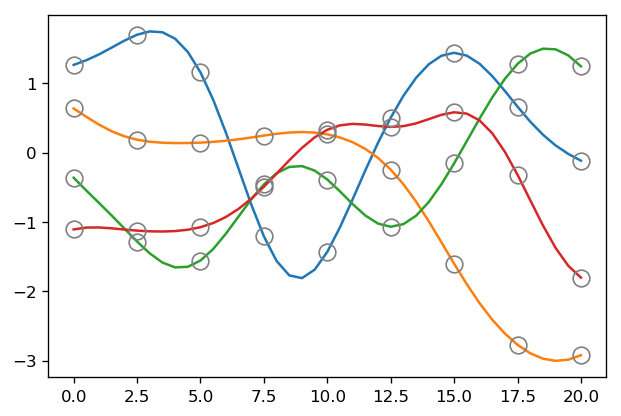

In [14]:
# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None)
toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
mean_full, cov_full = gp.predict(X_full, return_cov=True)

toy_data = toy_data_full[:, mask]
mean = mean_full[mask]
cov = cov_full[mask][:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Now if we take the data shown above, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

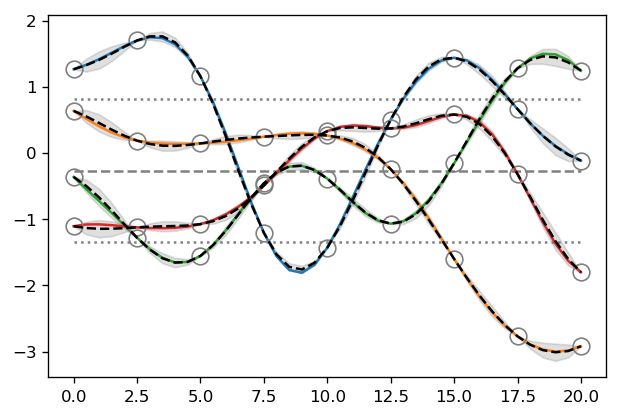

In [15]:
my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
# X_new = X_full[~mask]
# toy_data_pred = toy_data_full[:, ~mask]
X_new = X_full
toy_data_pred = toy_data_full
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

It worked! The mean and standard deviation are determined fairly well from the data. Not only that, the fits seem to interpolate in a reasonable manner. This should be expected, since the toy data were generated from a single GP whose kernel was assumed to be known. Plus, the length scale was fixed at the correct value.

We can do better than these "by eye" checks. What does B&O model checking say about this case? First, assume that we are checking the underlying process, shown by the constant gray dotted/dashed lines above, against the colored draws.

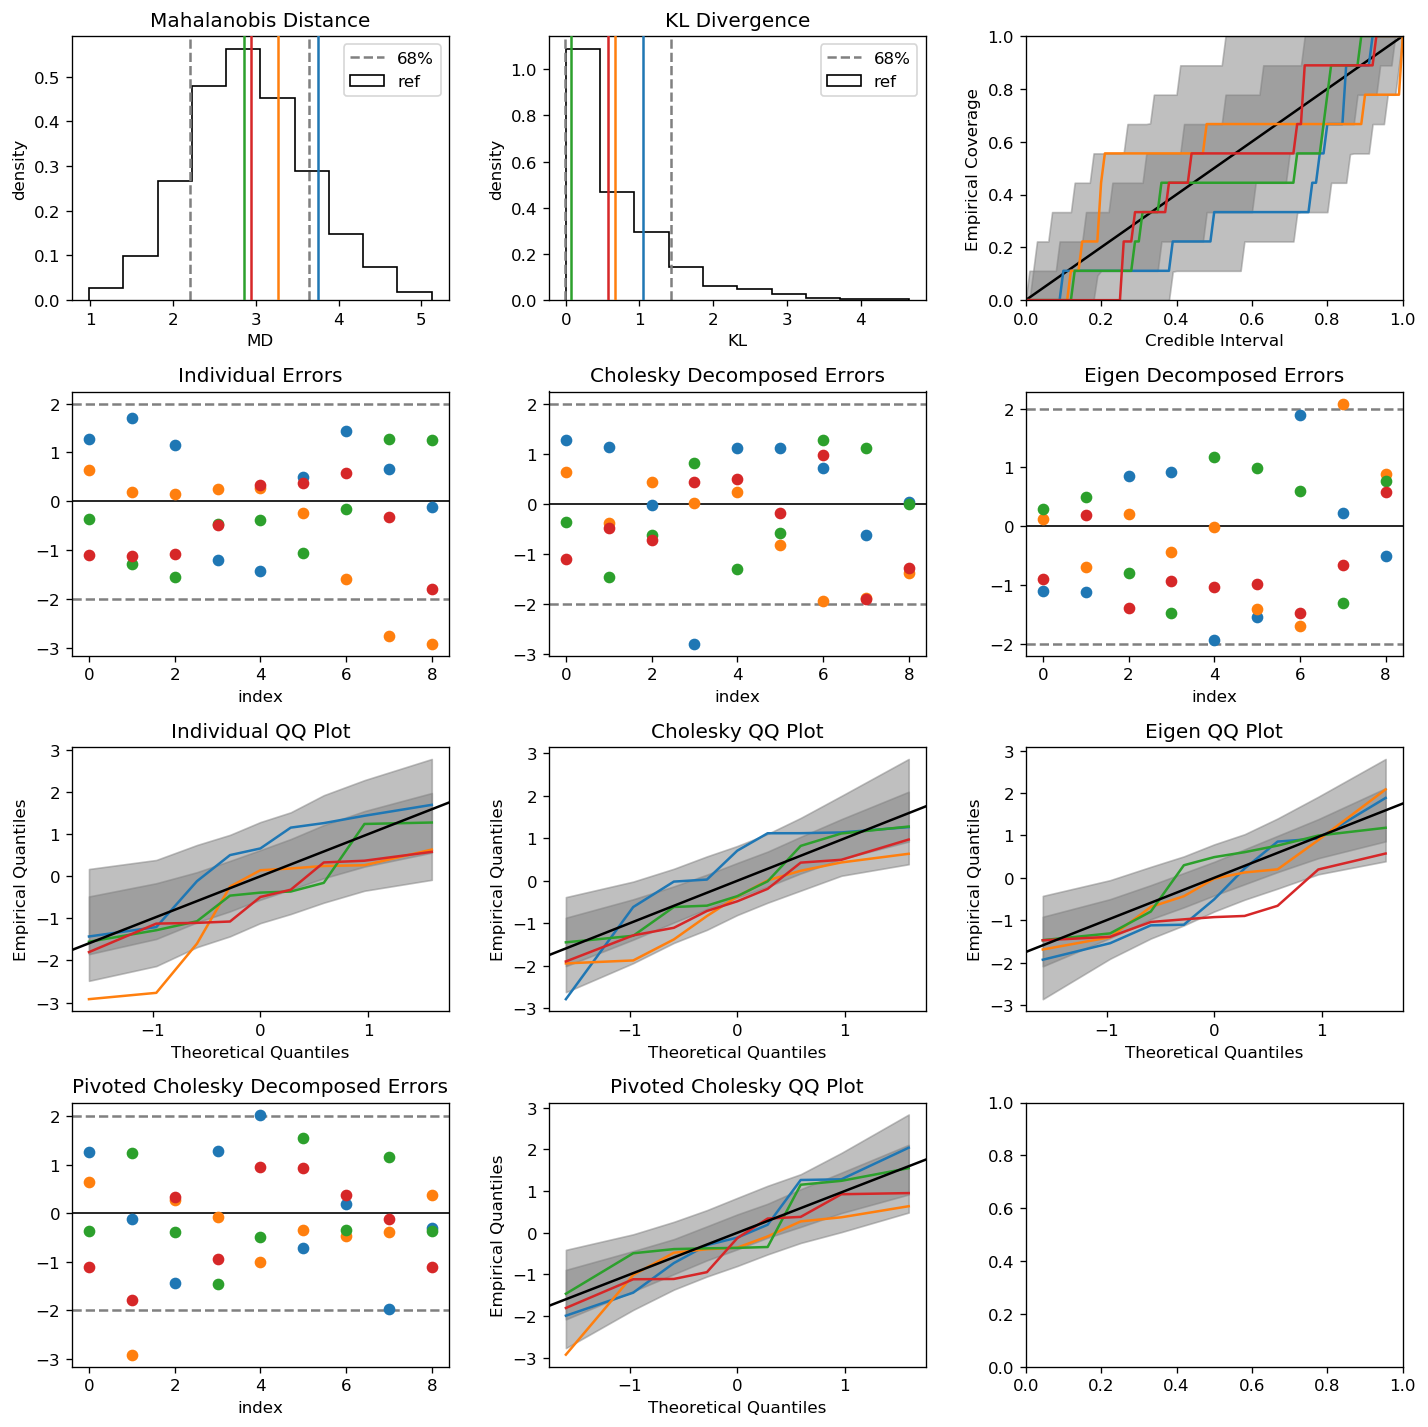

In [16]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gpmc = GPModelChecking(mean, cov)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp, vlines=vlines);

They each are within errors, as expected.

What if we use the full dataset?

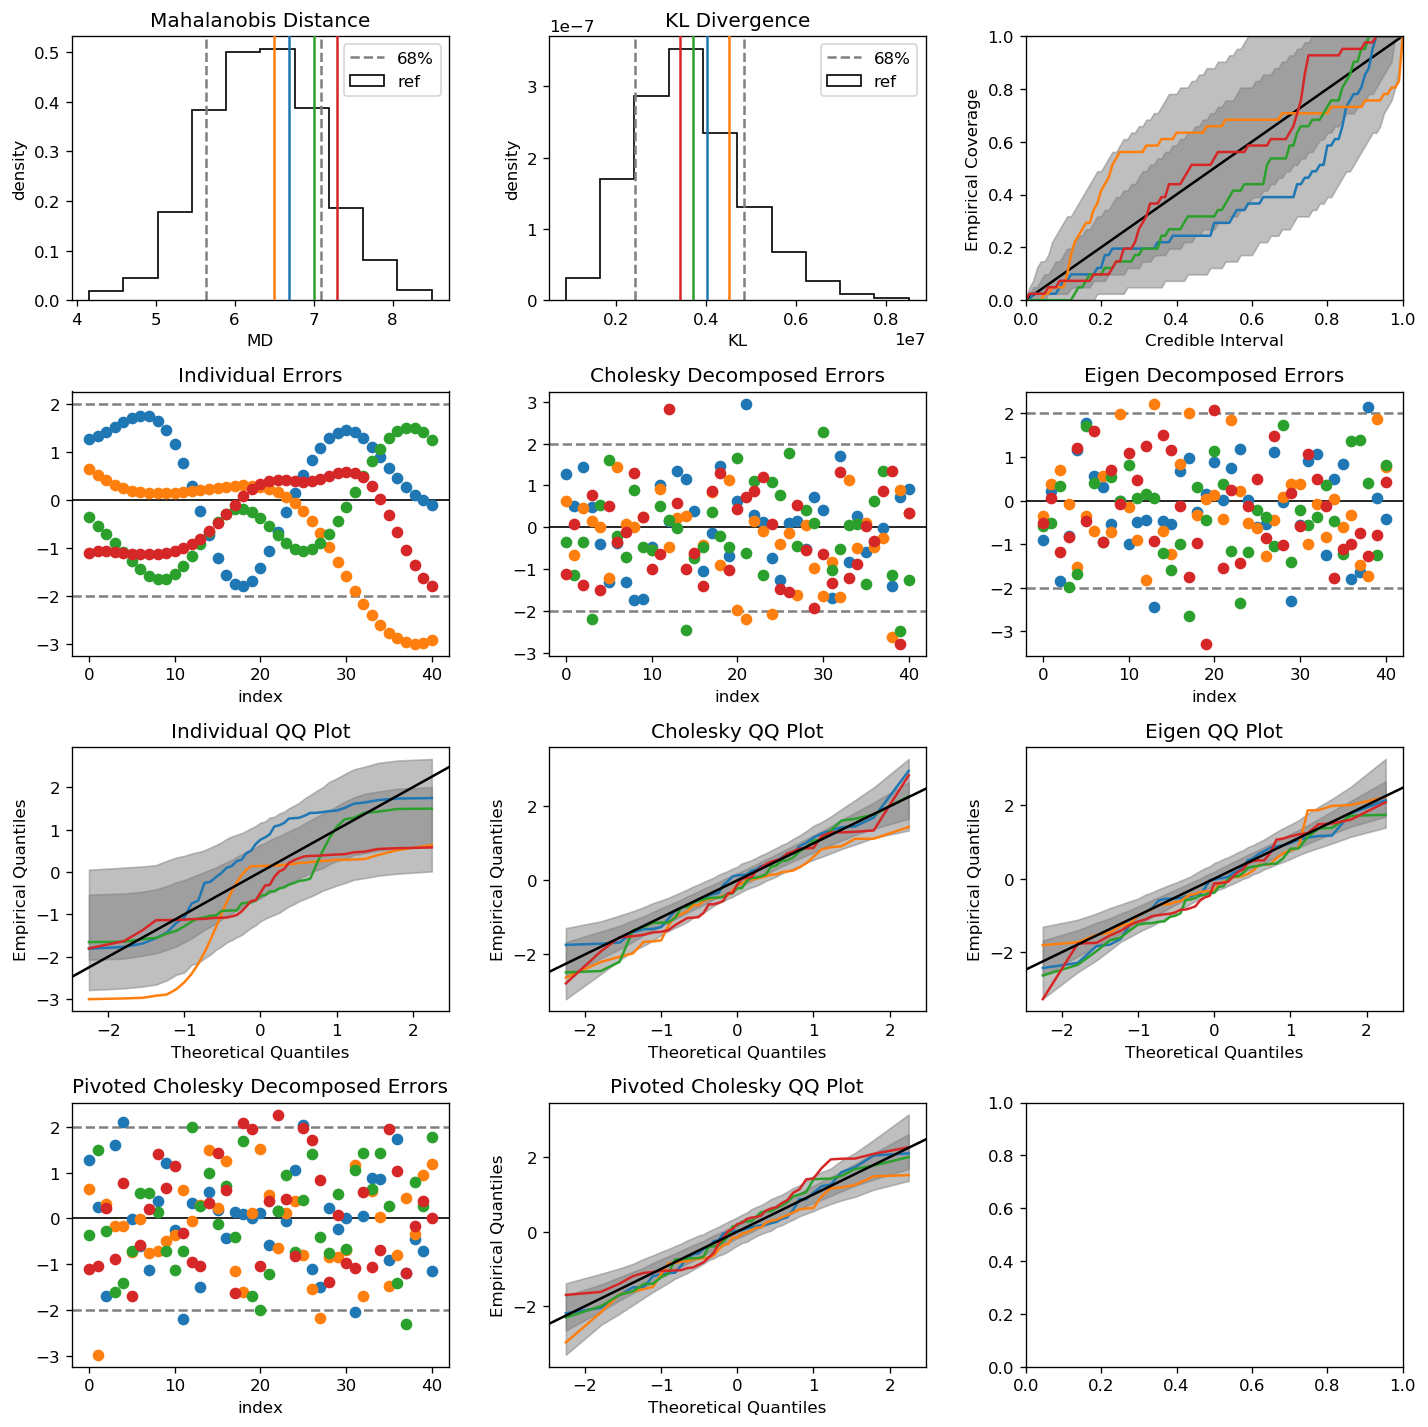

In [17]:
gp = ConjugateGaussianProcess(kernel)
gpmc_full = GPModelChecking(mean_full, cov_full)
gd_full = GraphicalDiagnostic(gpmc_full, toy_data_full, nref=n_ref)
gd_full.plotzilla(X_full, gp, vlines=vlines);

What if we performed the same model checking with the interpolants?
This time, we are comparing each colored curve to the process defined by the thin gray bands around that curve.
One potential clever way to combine the diagnostics from interpolated processes relies on the fact that the only thing that is different about the interpolating processes is their mean function that interpolates the data. If we subtract the means off the process and the data, then we are back to the simple iid case.

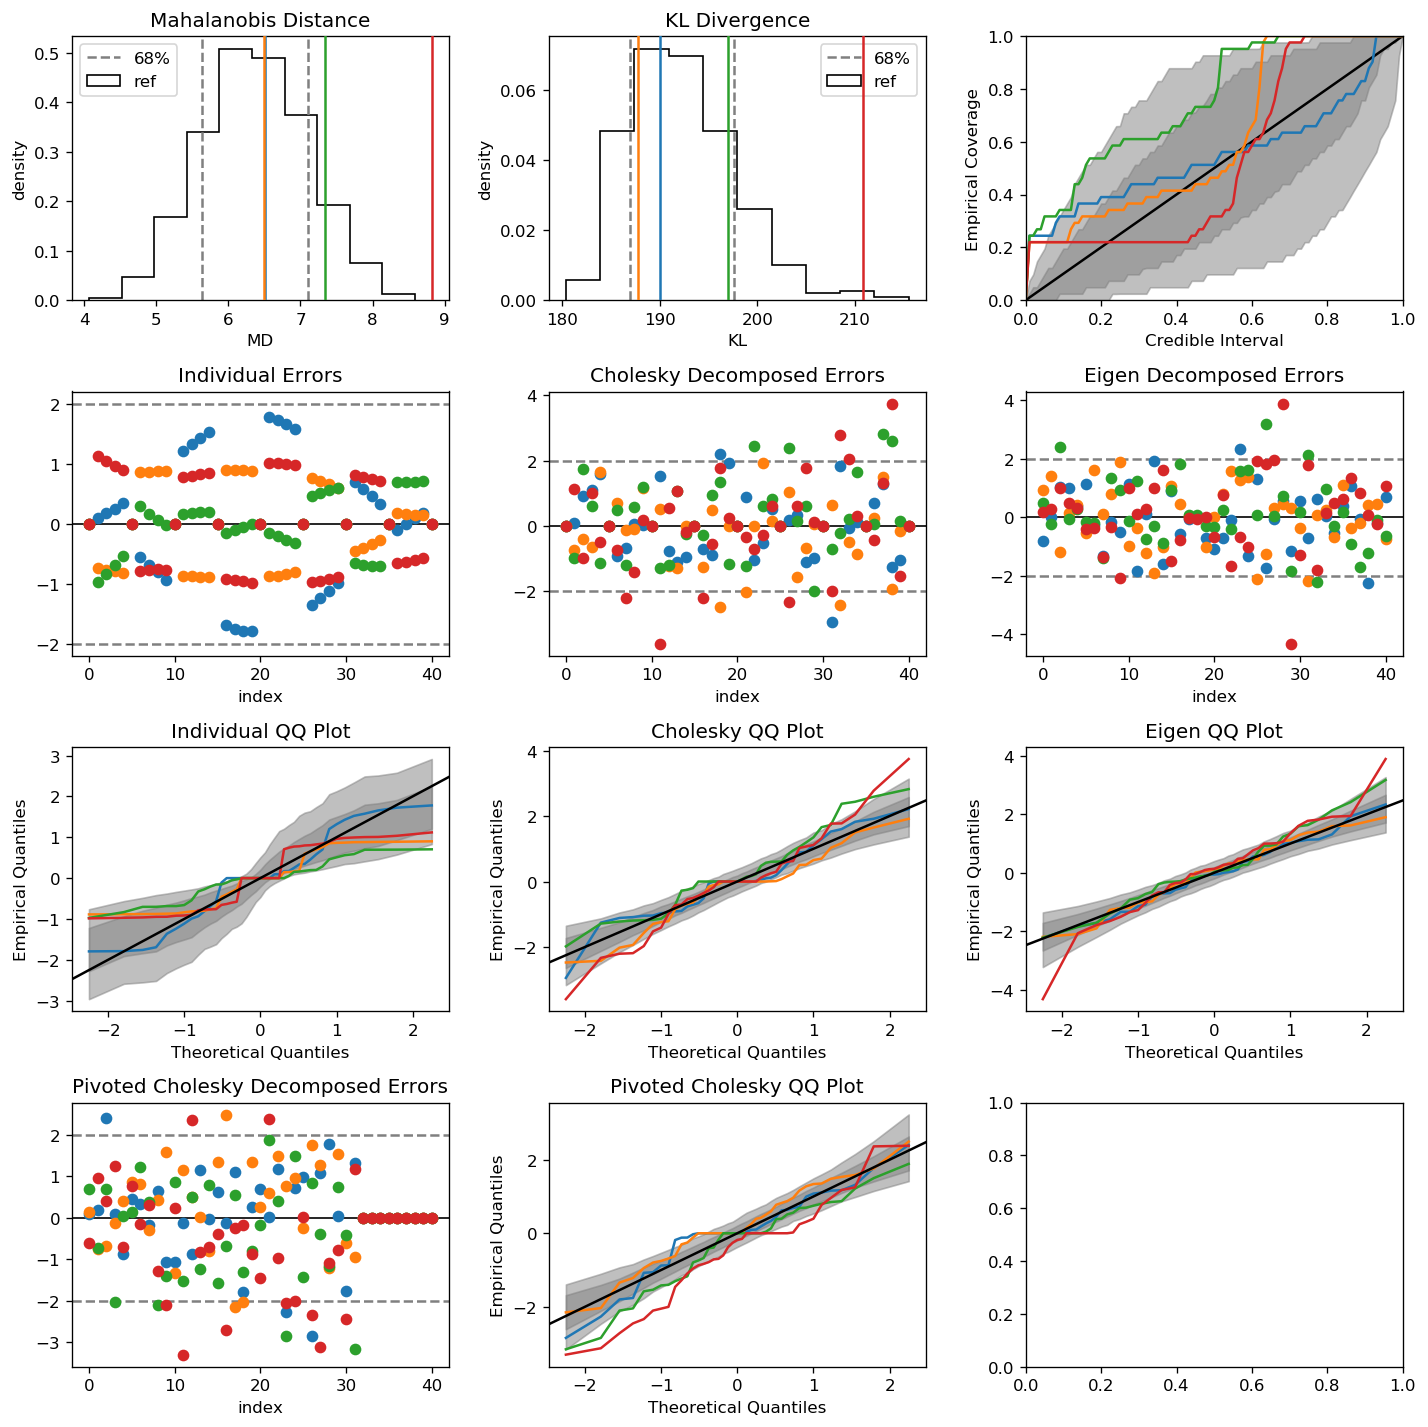

In [18]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel, v0=0)
gp.fit(X, toy_data, noise_sd=nugget_sd)
mean_est, cov_est = gp.predict(X_new, return_cov=True, pred_noise=True)
# print(mean_est.shape)
gpmc = GPModelChecking(np.zeros(m_pred.shape[1]), K_pred + nugget_sd**2 * np.eye(K_pred.shape[0]))
# gpmc = GPModelChecking(np.zeros_like(mean_est[0]), cov_est, df=2*gp.a())
gd = GraphicalDiagnostic(gpmc, toy_data_pred - m_pred, nref=n_ref)
gd.plotzilla(X_new, gp, predict=True, vlines=vlines);

These all look good! We should note that a nugget should be used across **all** covariances or else problems with ill-conditioned matrices arise.

Note that my answers tend to differ when computing, for example, the KL divergence when I use the "clever" method of combining diagnostics, although they are qualitatively similar:

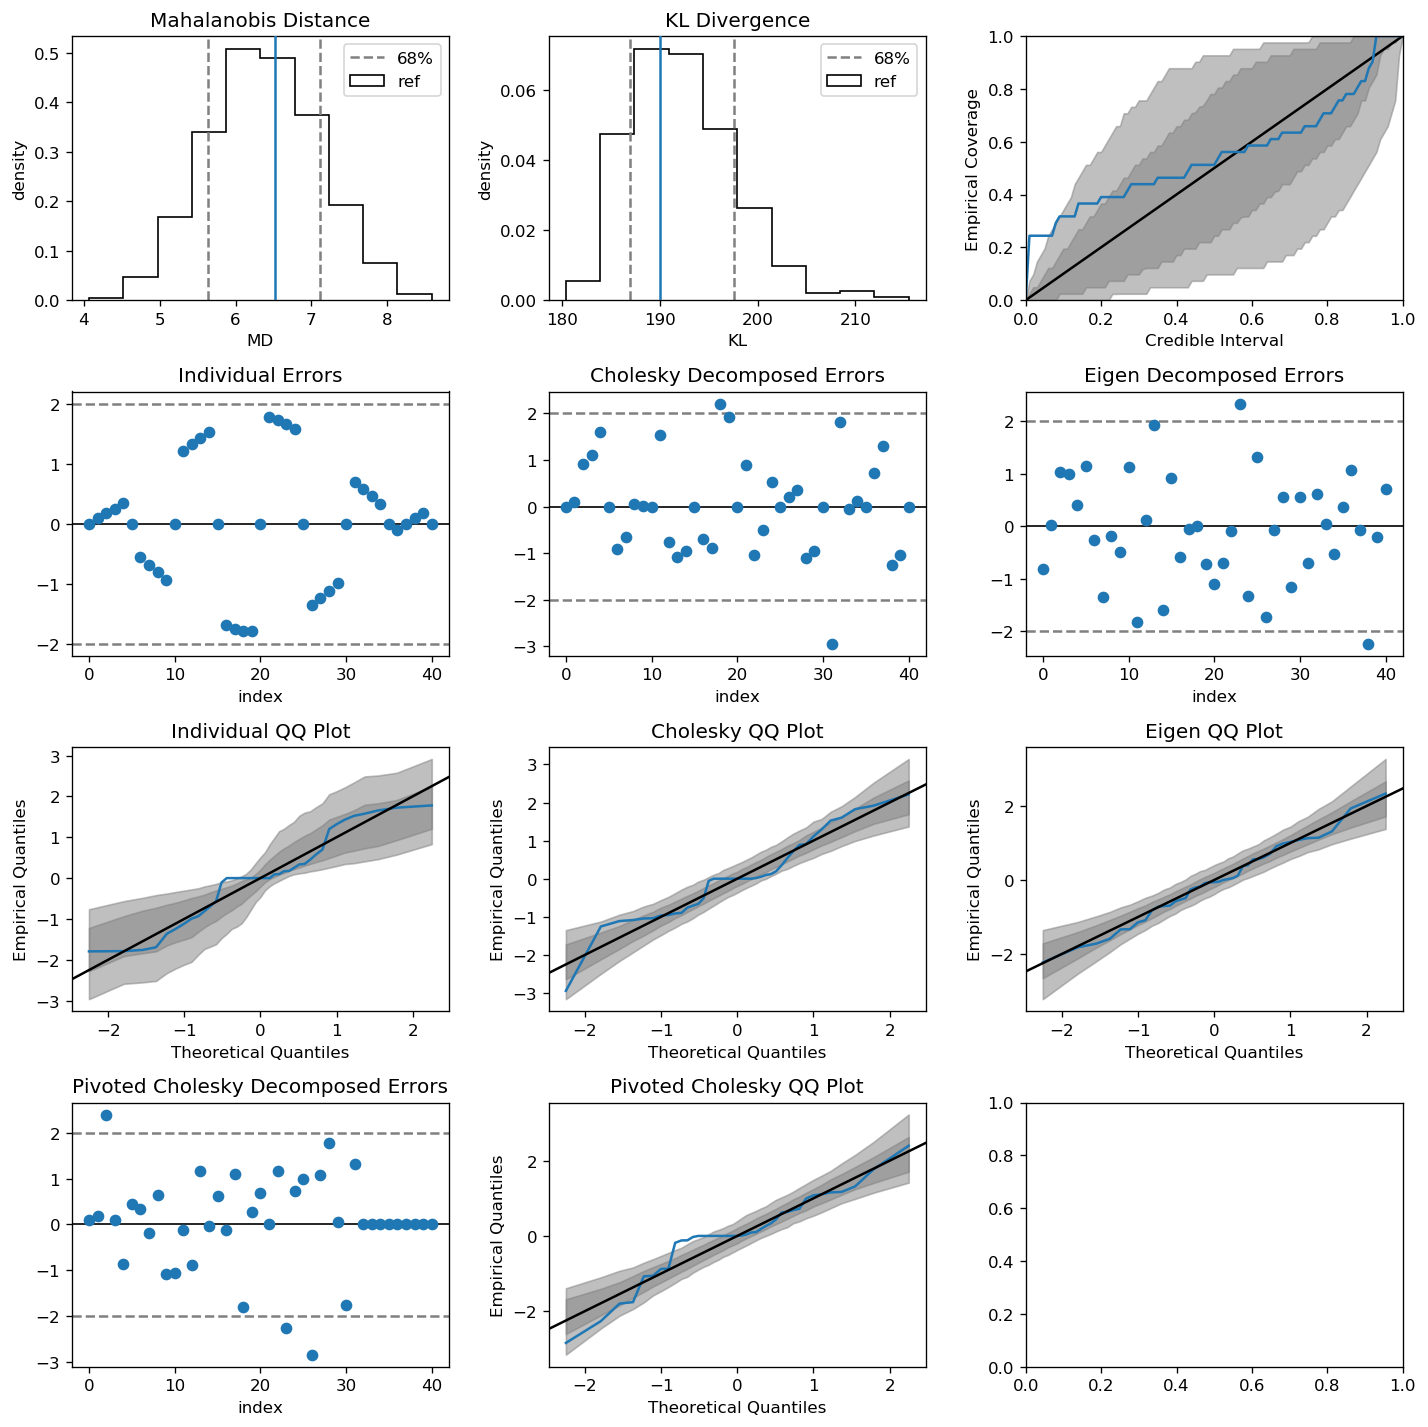

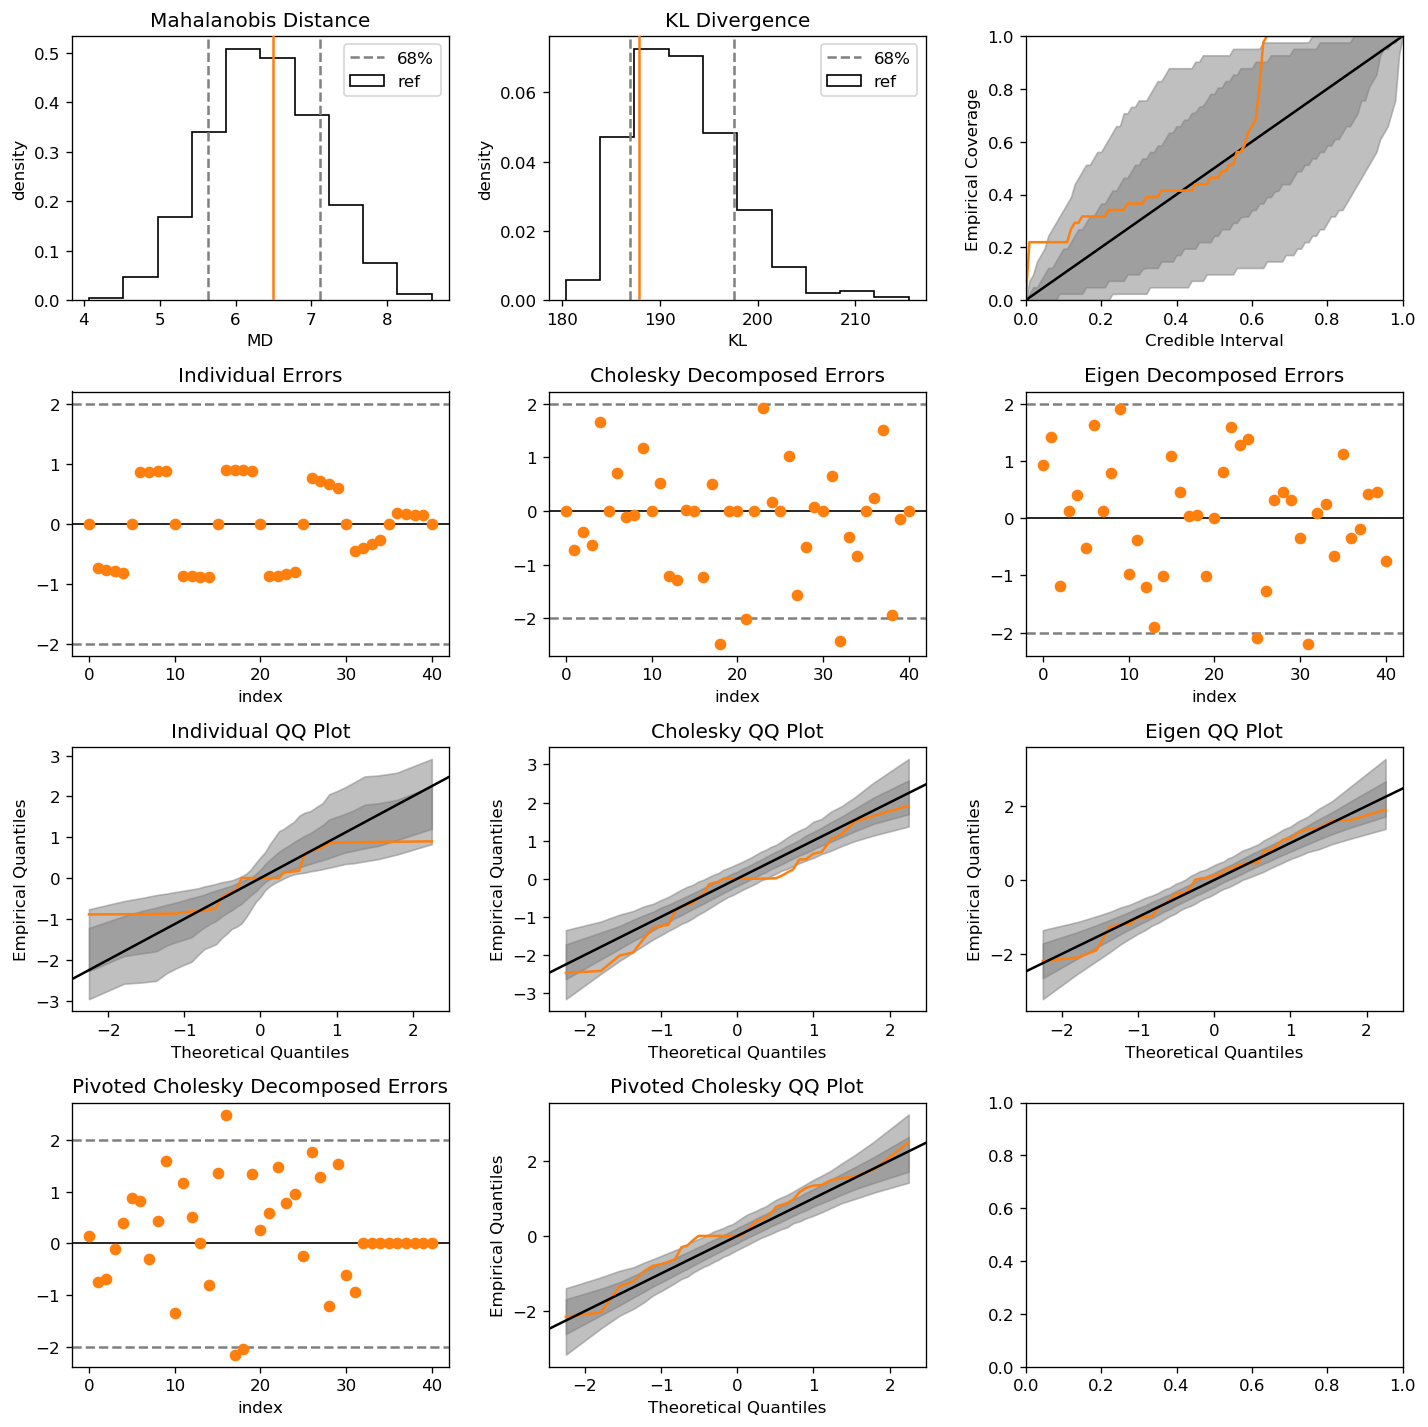

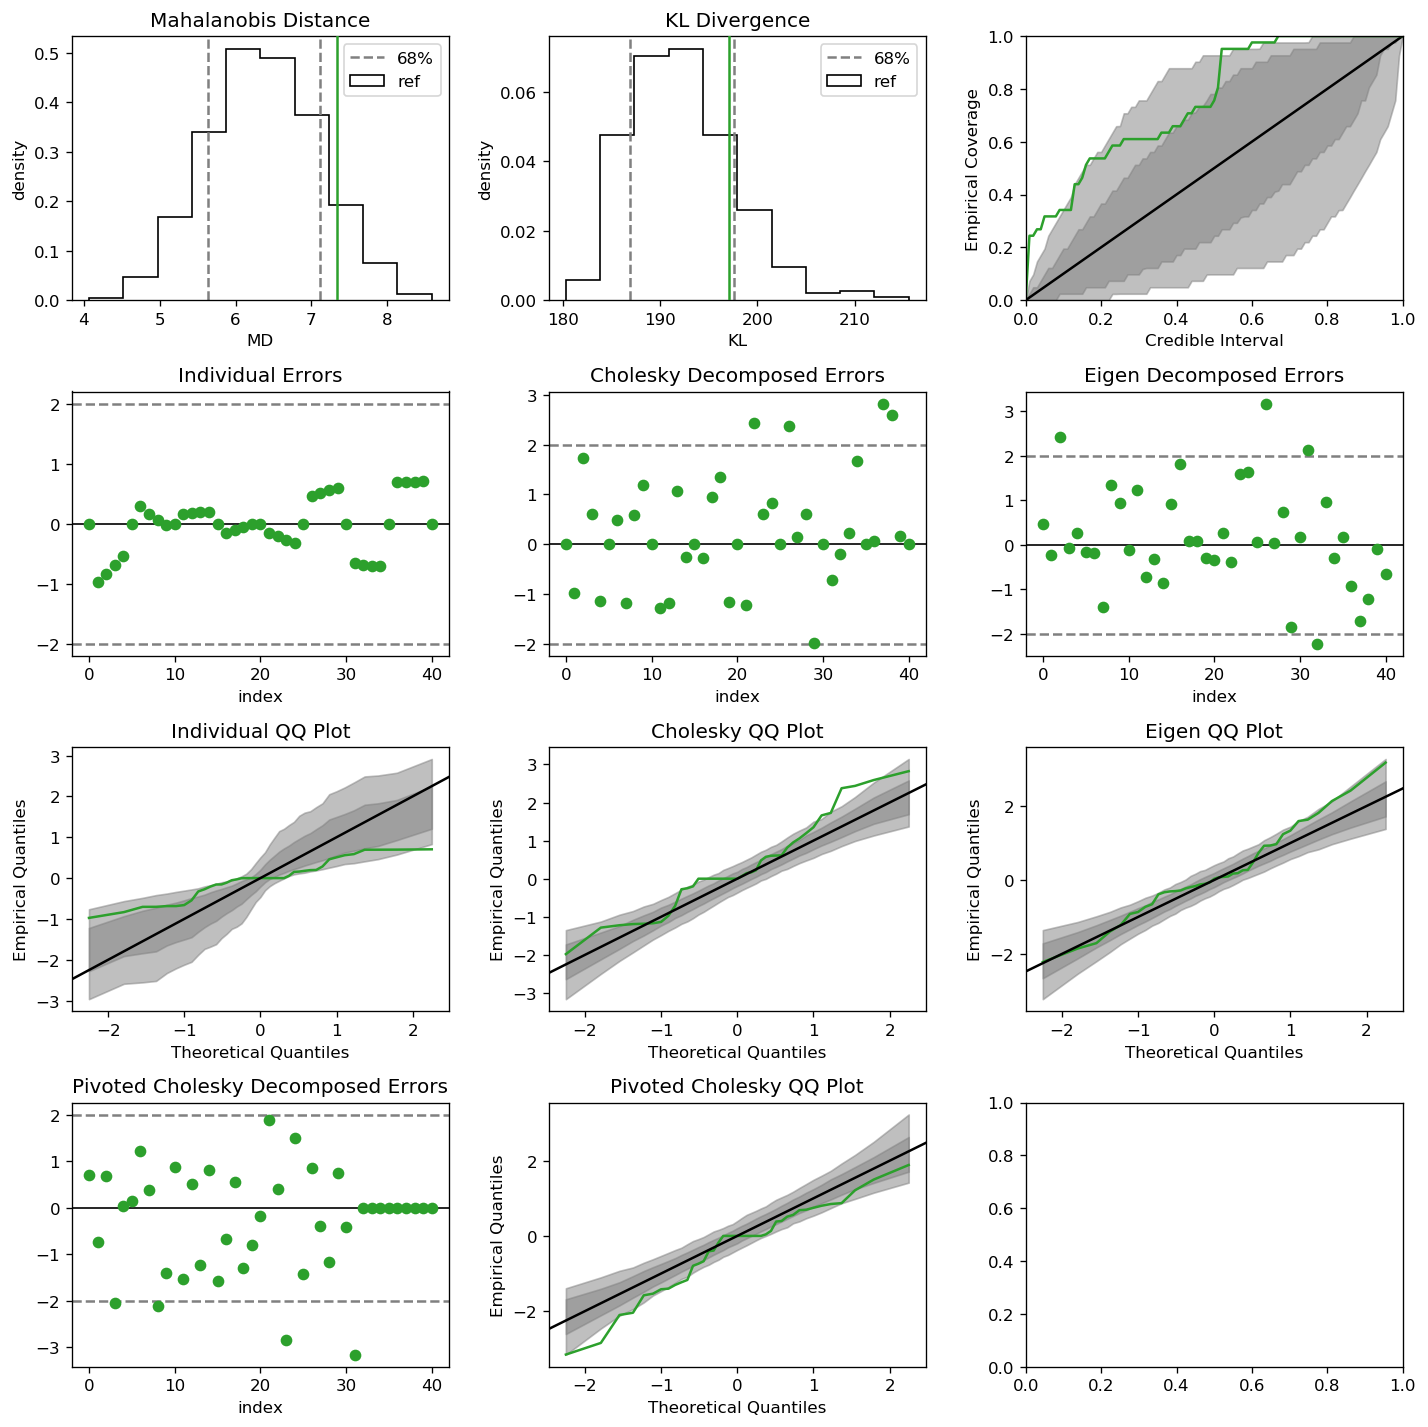

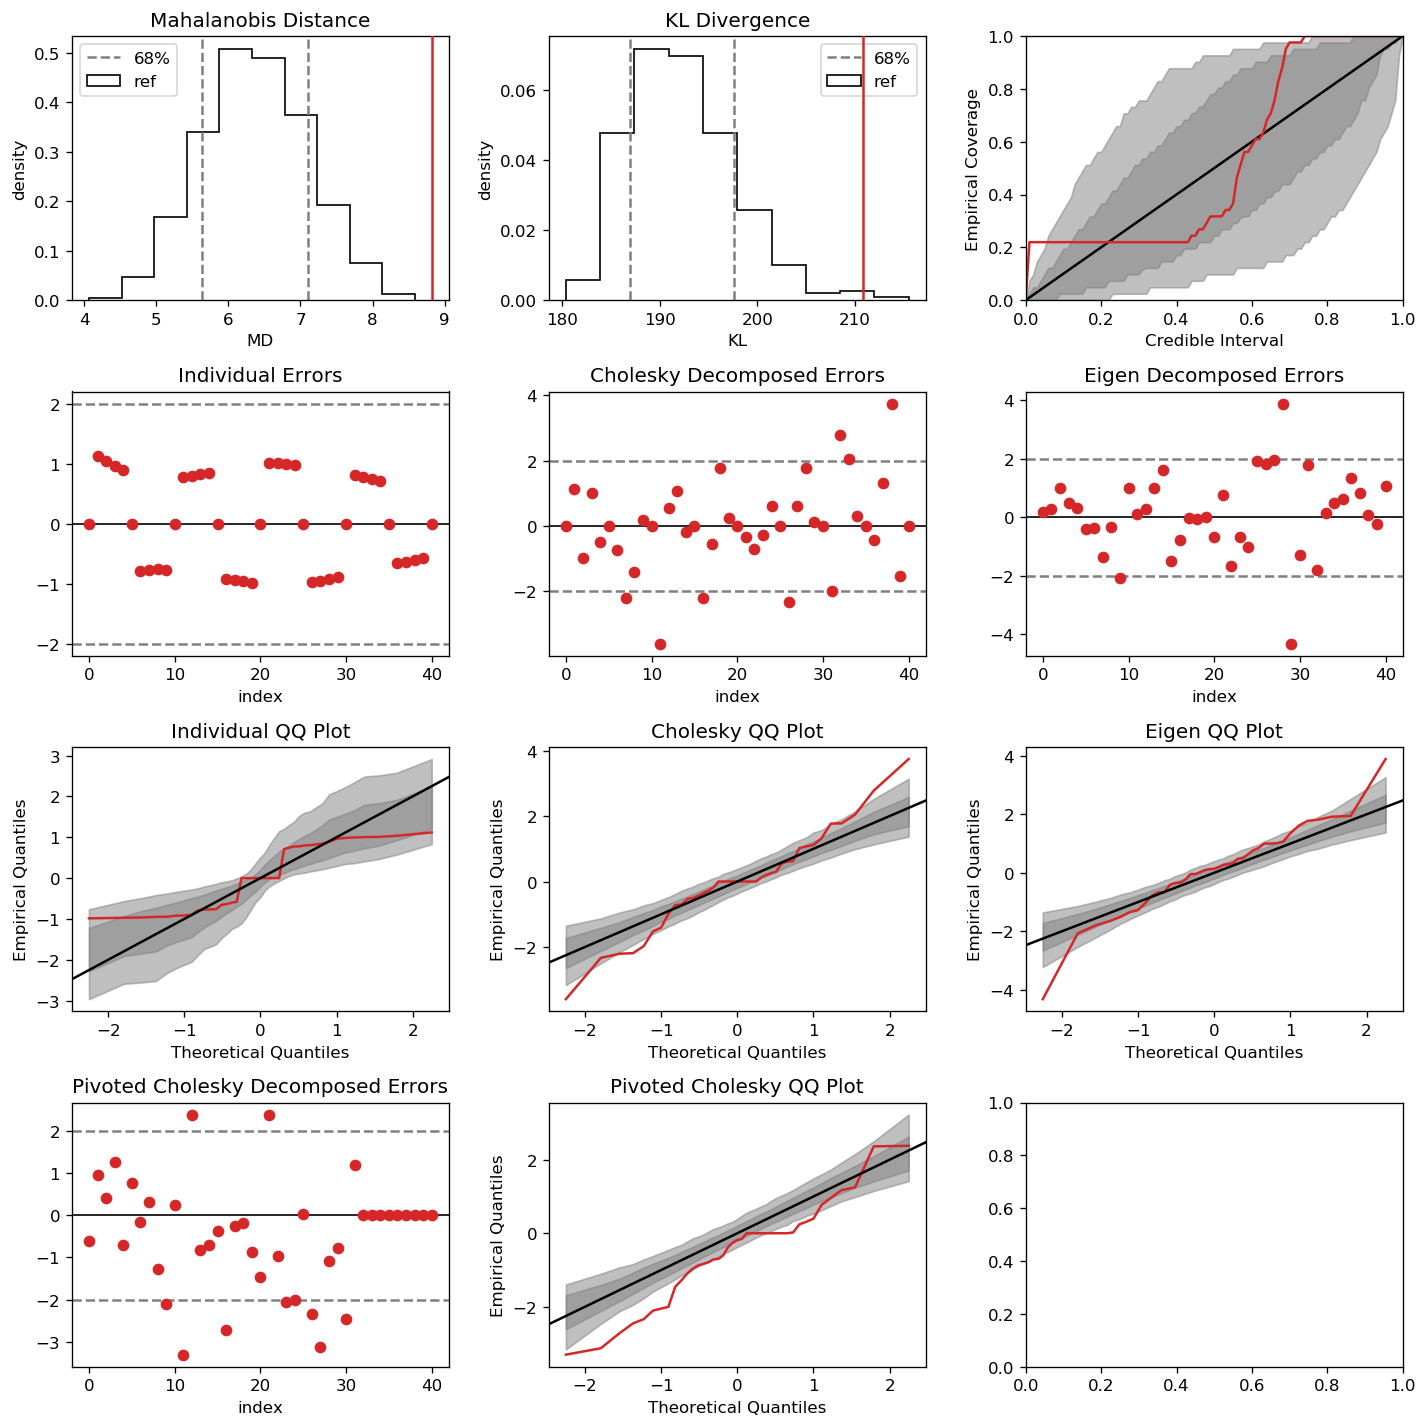

In [19]:
gp = ConjugateGaussianProcess(kernel, v0=0)
# Matplotlib 2.0 colors
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

for i, color in zip(range(len(toy_data)), cycle(new_colors)):
    np.random.seed(seed)
    # print('curve ' + str(i))
    gpmc = GPModelChecking(m_pred[i], K_pred + nugget_sd**2 * np.eye(K_pred.shape[0]))
    gd = GraphicalDiagnostic(gpmc, toy_data_full[i], nref=n_ref, colors=[color])
    gd.plotzilla(X_new, gp, predict=True);

## Todo

I want to improve the code, check for bugs/errors, add more examples, and add more model checking diagnostics. We must find where the model fails, and which diagnostics are most helpful when accepting/rejecting the model.

In [20]:
gp = ConjugateGaussianProcess(rbf)
gp.fit(X, toy_data, noise_sd=nugget_sd)
ls_mesh = np.linspace(0.1, 7, 100)
Rs = np.array([rbf(X, X, ls=L) for L in ls_mesh])
cholRs = np.linalg.cholesky(Rs + nugget_sd**2 * np.eye(Rs.shape[-1]))
# Rs = rbf(X, X, ls=3)
print(Rs.shape)
ls_loglike = gp.likelihood(log=True, corr_chol=cholRs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))
# print(ls_loglike, ls_like.shape)

(100, 9, 9)


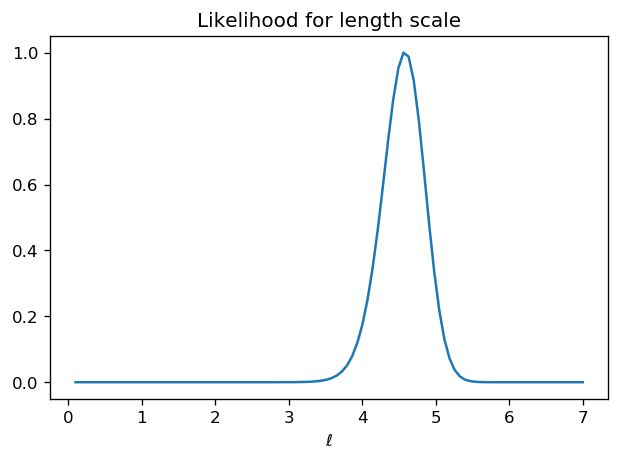

In [27]:
ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.plot(ls_mesh, ls_like);

In [28]:
ratio_param = np.linspace(0.1, 3, 20)
ratios = ratio_param[:, None] * np.ones(len(X))
joint_loglike = ratio_likelihood(ratios, gp, toy_data, cholRs)
joint_like = np.exp(joint_loglike - np.max(joint_loglike))

(20,) (100,) (20, 100)


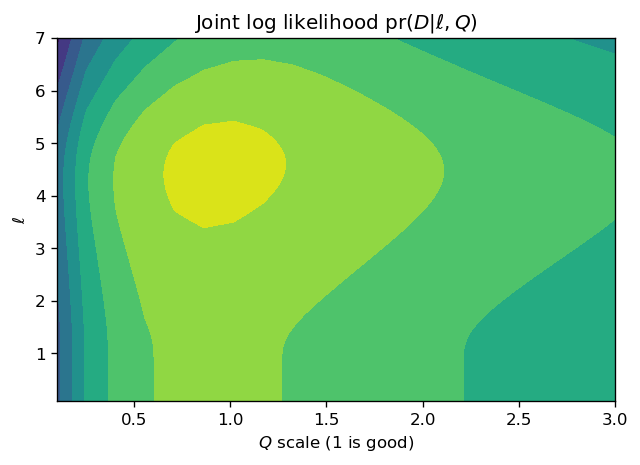

In [30]:
print(ratio_param.shape, ls_mesh.shape, joint_like.shape)
plt.contourf(ratio_param, ls_mesh, joint_loglike.T);
ax = plt.gca()
ax.set_title(r'Joint log likelihood pr$(D | \ell, Q)$')
ax.set_xlabel(r'$Q$ scale (1 is good)')
ax.set_ylabel(r'$\ell$');